In [1]:
import sys
import os
import numpy as np
import json

from sklearn.model_selection import train_test_split
import pandas as pd

import tensorflow as tf
import keras.backend.tensorflow_backend as K
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Activation, LSTM, CuDNNGRU, CuDNNLSTM
from keras.layers import Dropout, Conv1D, MaxPooling1D, GlobalMaxPool1D
from keras.layers import Bidirectional, InputLayer

from keras import regularizers 
from keras.callbacks import EarlyStopping, ModelCheckpoint, ModelCheckpoint

Using TensorFlow backend.


In [2]:
tf.set_random_seed(0)

## 데이터 로드

In [3]:
DATA_IN_PATH = './data/word_dict/'
DATA_OUT_PATH = './data_out/'
#INPUT_TRAIN_DATA = 'input.npy'
#LABEL_TRAIN_DATA = 'label.npy'
#DATA_CONFIGS = 'data_configs.json'

INPUT_TRAIN_DATA = 'pos_input.npy'
LABEL_TRAIN_DATA = 'pos_label.npy'
DATA_CONFIGS = 'pos_data_configs.json'

input_data = np.load(open(DATA_IN_PATH + INPUT_TRAIN_DATA, 'rb'))
label_data = np.load(open(DATA_IN_PATH + LABEL_TRAIN_DATA, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r',  -1, "utf-8"))

In [4]:
TEST_SPLIT = 0.1
RND_SEED = 0
VOCAB_SIZE = prepro_configs['vocab_size']+1
EMB_SIZE = 128
BATCH_SIZE = 512
MAX_LEN = 200
max_features = 20000

In [5]:
train_input, eval_input, train_label, eval_label = train_test_split(input_data,
                                                                    label_data,
                                                                    test_size=TEST_SPLIT,
                                                                    random_state=RND_SEED)

In [6]:
train_input = sequence.pad_sequences(train_input, maxlen=MAX_LEN)
eval_input = sequence.pad_sequences(eval_input, maxlen=MAX_LEN)

## 모델 설정

In [7]:
def Model():
    model = Sequential()
    model.add(Embedding(max_features, EMB_SIZE, input_length=MAX_LEN))    
    model.add(Bidirectional(LSTM(60, return_sequences=True, dropout=0.3, recurrent_dropout=0.1)))
    model.add(GlobalMaxPool1D())
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [8]:
model = Model()

model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer='rmsprop', metrics=['accuracy'])
model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 128)          2560000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 120)          90720     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 120)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                6050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
__________________________

In [9]:
# 최선의 모델 model 저장
MODEL_PATH = './model/'
if not os.path.exists(MODEL_PATH):
    os.mkdir(MODEL_PATH)

model_full_path = MODEL_PATH + 'best_train_model.hdf5'

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min')
check_point = ModelCheckpoint(filepath=model_full_path, monitor='val_loss', verbose=1, save_best_only=True)

In [11]:
with K.tf_ops.device('/device:GPU:0'):
    hist = model.fit(train_input, train_label, batch_size = BATCH_SIZE,
                     epochs = 10, validation_split = 0.2, callbacks=[early_stopping, check_point])


Train on 6687 samples, validate on 1672 samples
Epoch 1/10
6687/6687 [==============================] - 5s 802us/step - loss: 0.5671 - accuracy: 0.7709 - val_loss: 0.5375 - val_accuracy: 0.7811

Epoch 00001: val_loss improved from inf to 0.53749, saving model to ./model/best_train_model.hdf5
Epoch 2/10
6687/6687 [==============================] - 4s 663us/step - loss: 0.5355 - accuracy: 0.7734 - val_loss: 0.5159 - val_accuracy: 0.7811

Epoch 00002: val_loss improved from 0.53749 to 0.51595, saving model to ./model/best_train_model.hdf5
Epoch 3/10
6687/6687 [==============================] - 4s 646us/step - loss: 0.5092 - accuracy: 0.7739 - val_loss: 0.5003 - val_accuracy: 0.7811

Epoch 00003: val_loss improved from 0.51595 to 0.50032, saving model to ./model/best_train_model.hdf5
Epoch 4/10
6687/6687 [==============================] - 4s 651us/step - loss: 0.4407 - accuracy: 0.8038 - val_loss: 0.4484 - val_accuracy: 0.8050

Epoch 00004: val_loss improved from 0.50032 to 0.44844, savin

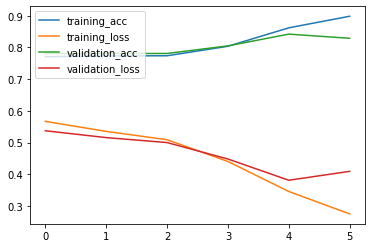

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['val_loss'])
plt.legend(['training_acc', 'training_loss','validation_acc', 'validation_loss'], loc = 'upper left')
plt.show()

In [13]:
results = model.evaluate(eval_input, eval_label)
print('Test accuracy: ', results[1])

929/929 [==============================] - 3s 4ms/step
Test accuracy:  0.8320775032043457


## 모델 사용 

In [14]:
#model.predict_classes(train_input[:8])

In [15]:
#hist.history

## K-fold validation 사용 

In [16]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=20, random_state=RND_SEED, shuffle=True)

for train_index, test_index in kf.split(input_data):
    X_train, X_test = input_data[train_index], input_data[test_index]
    y_train, y_test = label_data[train_index], label_data[test_index]
    
X_train = sequence.pad_sequences(X_train, maxlen=MAX_LEN)
X_test = sequence.pad_sequences(X_test, maxlen=MAX_LEN)

In [17]:
model = Model()

model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer='rmsprop', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 128)          2560000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200, 120)          90720     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 120)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                6050      
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [18]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min')

In [19]:
with K.tf_ops.device('/device:GPU:0'):
        hist = model.fit(X_train, y_train, batch_size = BATCH_SIZE,
                     epochs = 10)

Epoch 1/10
8824/8824 [==============================] - 6s 633us/step - loss: 0.5691 - accuracy: 0.7407
Epoch 2/10
8824/8824 [==============================] - 5s 566us/step - loss: 0.5180 - accuracy: 0.7748
Epoch 3/10
8824/8824 [==============================] - 5s 570us/step - loss: 0.4377 - accuracy: 0.8088
Epoch 4/10
8824/8824 [==============================] - 5s 563us/step - loss: 0.3380 - accuracy: 0.8680
Epoch 5/10
8824/8824 [==============================] - 5s 557us/step - loss: 0.2700 - accuracy: 0.9005
Epoch 6/10
8824/8824 [==============================] - 5s 564us/step - loss: 0.2252 - accuracy: 0.9173
Epoch 7/10
8824/8824 [==============================] - 5s 565us/step - loss: 0.1931 - accuracy: 0.9328
Epoch 8/10
8824/8824 [==============================] - 5s 574us/step - loss: 0.1683 - accuracy: 0.9406
Epoch 9/10
8824/8824 [==============================] - 5s 568us/step - loss: 0.1418 - accuracy: 0.9512
Epoch 10/10
8824/8824 [==============================] - 5s 557u

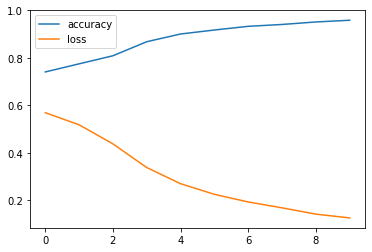

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['loss'])
plt.legend(['accuracy', 'loss'], loc = 'upper left')
plt.show()

In [21]:
score = model.evaluate(X_test,y_test)
print('Test accuracy: ', score[1])

464/464 [==============================] - 2s 4ms/step
Test accuracy:  0.8620689511299133


## VDCNN 